# ML Decoder for classical code

In [229]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import galois

import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision

In [230]:
def tanner_graph(H: np.ndarray):
    "Create tanner graph from a parity check matrix H."
    m, n = H.shape
    T = nx.Graph()

    T.H = H
    # nodes
    T.VD = [i for i in range(n)]
    T.VC = [-j-1 for j in range(m)]

    # add them, with positions
    for i, node in enumerate(T.VD):
        T.add_node(node, pos=(i-n/2, 0), label='$d_{'+str(i)+'}$')
    for j, node in enumerate(T.VC):
        T.add_node(node, pos=(j-m/2, 1), label='$c_{'+str(j)+'}$')

    # add checks to graph
    for j, check in enumerate(H):
        for i, v in enumerate(check):
            if v:
                T.add_edge(-j-1, i)

    return T

def draw_tanner_graph(T, highlight_vertices=None):
    "Draw the graph. highlight_vertices is a list of vertices to be colored."
    pl=nx.get_node_attributes(T,'pos')
    lbls = nx.get_node_attributes(T, 'label')

    nx.draw_networkx_nodes(T, pos=pl, nodelist=T.VD, node_shape='o')
    nx.draw_networkx_nodes(T, pos=pl, nodelist=T.VC, node_shape='s')
    nx.draw_networkx_labels(T, pos=pl, labels=lbls)

    nx.draw_networkx_edges(T, pos=pl)

    if highlight_vertices:
        nx.draw_networkx_nodes(T,
                               pos=pl,
                               nodelist=[int(v[:]) for v in highlight_vertices if v[0] == 'd'],
                               node_color='red',
                               node_shape='o')
        nx.draw_networkx_nodes(T,
                       pos=pl,
                       nodelist=[-int(v[:])-1 for v in highlight_vertices if v[0] == 'c'],
                       node_color='red',
                       node_shape='s')

    plt.axis('off');

# these four functions allow us to convert between 
# (s)tring names of vertices and (i)nteger names of vertices
def s2i(node):
    return int(node[1]) if node[0] == 'd' else -int(node[1])-1

def i2s(node):
    return f'd{node}' if node>=0 else f'c{-node-1}'

def ms2i(W: set):
    return set(map(s2i, W))

def mi2s(W: set):
    return set(map(i2s, W))

 ## We will try to train a decoder for the [5,2,3] code
 * 5 qubits
 * 2 logicals
 * distance 3

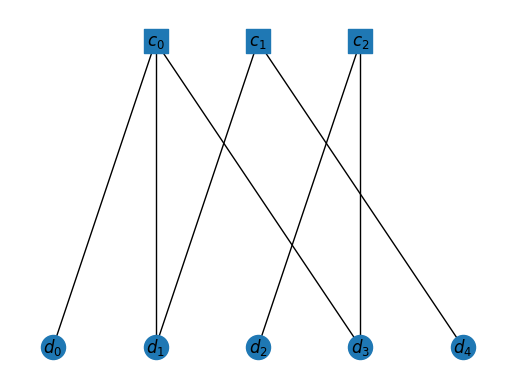

In [231]:
H = np.array([[1,1,0,1,0], [0,1,0,0,1], [0,0,1,1,0]])

T = tanner_graph(H)
draw_tanner_graph(T)

n_qubits = H.shape[1]
n_stab = H.shape[0]

The distance is 3 so we will train the decoder on errors configurations with at most 2 errors.

Lets create a dictionary between at most 2 error configurations and integers

In [232]:
E_list = [torch.tensor([0]*5, dtype=torch.float)]

for i in range(5):
    for j in range(i,5):
        E = [0]*5
        E[i] = 1
        if j>=i:
            E[j] = 1
        E_list.append(torch.tensor(E, dtype = torch.int))


num_to_E_dictionary = {}
num_to_one_hot = {}
for i, E in enumerate(E_list):
    num_to_E_dictionary[i] = E
    num_to_one_hot[i] = F.one_hot(torch.tensor([i]), num_classes = len(E_list)).to(float)


In [233]:
num_to_one_hot[1].view(len(E_list))

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)

In [234]:
def Error():
    num = np.random.randint(0,len(E_list))
    error = num_to_E_dictionary[num]

    return error

Let's make data set: [(syndrome, error)]

In [235]:
error_num_dataset = []
N_dataset = 10**4

while len(error_num_dataset) <N_dataset:
    num = np.random.randint(0,len(E_list))
    error_one_hot = num_to_one_hot[num]
    error = num_to_E_dictionary[num]
    syndrome = (H @ np.array(error))%2
    error_num_dataset.append((torch.tensor(syndrome, dtype = torch.float), error_one_hot.view(len(E_list))))

In [265]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(3,250)
        self.Matrix2 = nn.Linear(250,50)
        self.Matrix3 = nn.Linear(50,100)
        self.Matrix4 = nn.Linear(100,len(E_list))
        self.R = nn.ReLU()
    def forward(self,x):
        x = x.view(-1,3)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.R(self.Matrix3(x))
        x = self.Matrix4(x)
        return x.squeeze()

In [266]:
f = MyNeuralNet()

In [267]:
train_dl = DataLoader(error_num_dataset, batch_size= 5)

Now lets train:

In [268]:
max_epoch = 40

def train_model(dl, f, n_epochs = max_epoch):
    opt = SGD(f.parameters(), lr = .01)
    L = nn.CrossEntropyLoss()

    losses = []
    epochs = []
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}')
        N = len(dl)

        for i, (x,y) in enumerate(dl):
            opt.zero_grad()
            loss_value = L(f(x), y)
            loss_value.backward()
            opt.step()
            # store training history

            epochs.append(epoch +i/N)
            losses.append(loss_value.item())
        
    return np.array(epochs), np.array(losses)

In [269]:
epoch_data, loss_data = train_model(train_dl,f)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39


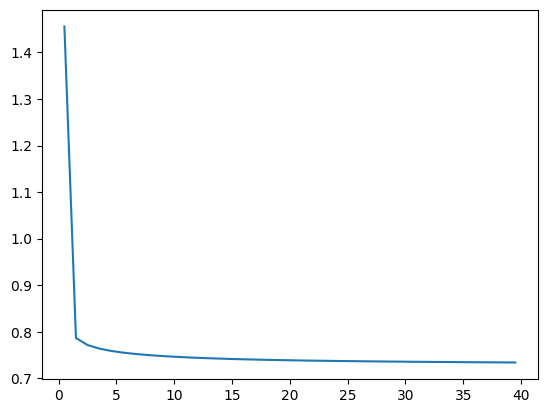

In [270]:
plt.plot(epoch_data.reshape(max_epoch,-1).mean(axis=1), loss_data.reshape(max_epoch,-1).mean(axis=1))

No let's test

In [271]:
test_data_set = []
N_dataset = 10**4

while len(test_data_set) <N_dataset:
    num = np.random.randint(0,len(E_list))
    error_one_hot = num_to_one_hot[num]
    error = num_to_E_dictionary[num]
    syndrome = (H @ np.array(error))%2
    test_data_set.append((torch.tensor(syndrome, dtype = torch.float), error_one_hot.view(len(E_list)), num))

Now lets test error correction performance:

In [272]:
L1 = np.array([1,1,1,1,1])
L2 = np.array([0,1,0,0,1])

In [273]:
N = len(test_data_set)
success = 0
for i, (x,y,z) in enumerate(test_data_set):
    pred_num = f(x).argmax().item()
    pred_error = np.array(num_to_E_dictionary[pred_num])

    true_error = np.array(num_to_E_dictionary[z])

    if (L1 @ (true_error-pred_error))%2 ==0 and (L2 @ (true_error-pred_error))%2 ==0:
        success+=1


print(f'info preserved {success/N} percent')


info preserved 0.6888 percent


In [274]:
test_data_set[0][0].argmax().item()

0